In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
## Importing dataset
secom = pd.read_spss('secom_mod.sav')

### Splitting the data 20% goes for testing

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

y = secom['class']
X = secom.drop(['class', 'ID', 'timestamp'], axis='columns')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_train = X_train.copy()
X_test = X_test.copy()

print(f'''% Positive class in Train = {np.round(y_train.value_counts(normalize=True)[1] * 100, 2)}
% Positive class in Test  = {np.round(y_test.value_counts(normalize=True)[1] * 100, 2)}''')

% Positive class in Train = 6.38
% Positive class in Test  = 4.78


In [4]:
pd.set_option('display.max_columns', None)

### Changing types of target feature to be Categorical

In [5]:
y_train = y_train.astype('category')
y_test = y_test.astype('category') 
assert y_train.dtype == 'category'

### Feature Selection

### Now We look for null values overpassing the 45% on the features

In [6]:
numericalFeatures = X_train.iloc[:,2:-1]

#### A graphical representation of current null values

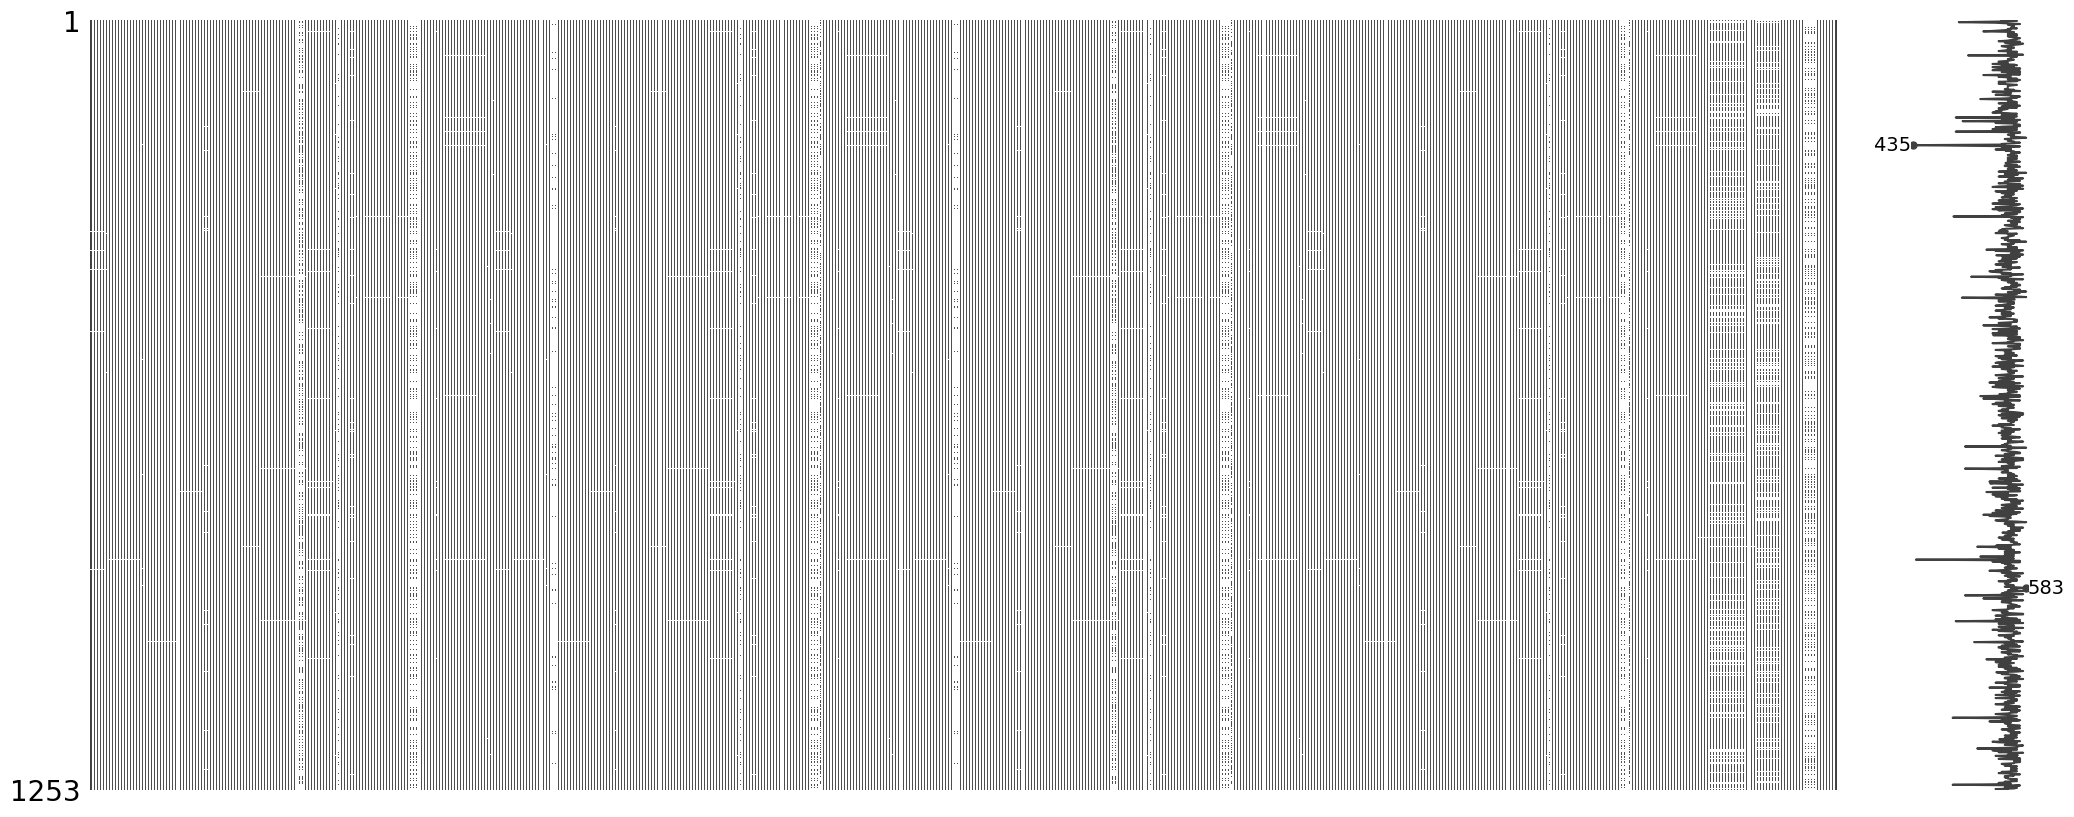

In [7]:
import missingno as msno

msno.matrix(numericalFeatures.head(1000000))
plt.show()

#### Checking if there is a column with more than 55% values missing or NaN

In [8]:
num_of_features_to_delete = 0
colsToDrop = []
for col in numericalFeatures.columns:
    if (numericalFeatures[col].isna().sum() > 700):
        num_of_features_to_delete +=1
        
        colsToDrop.append(col)
        
X_train.drop(colsToDrop, axis=1, inplace=True)
X_test.drop(colsToDrop, axis=1, inplace=True)

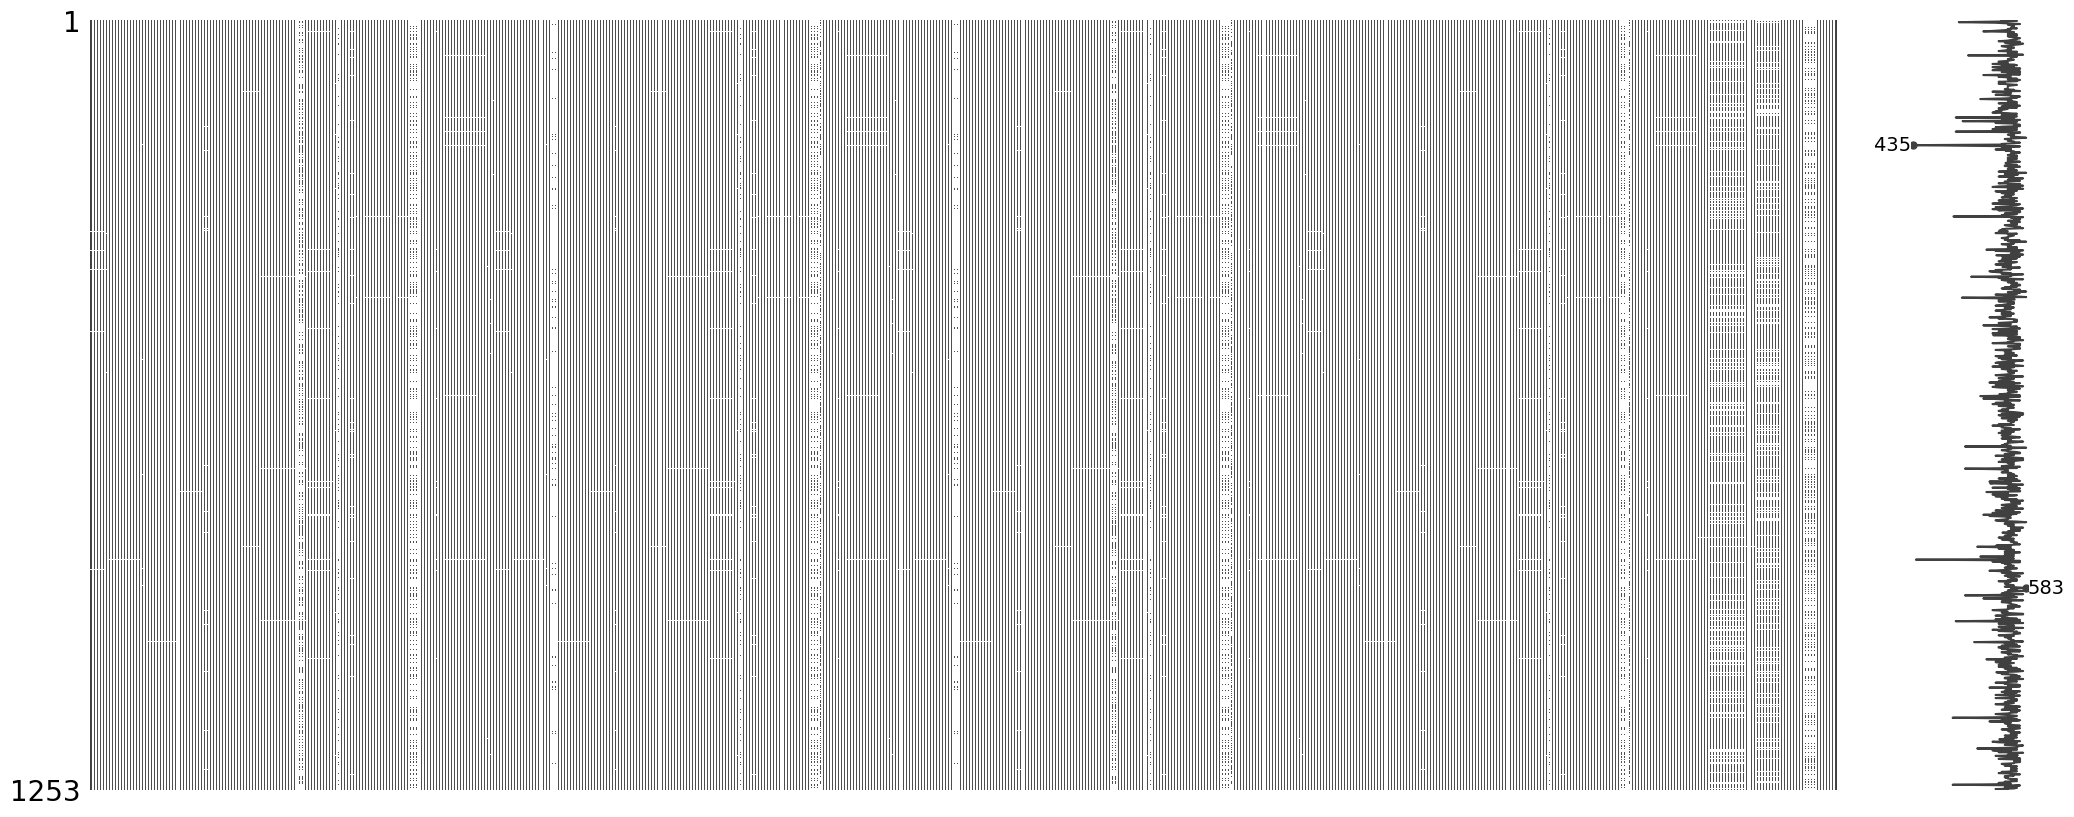

In [9]:
msno.matrix(numericalFeatures)
plt.show()

After deleting columns with nulls more than 45% of missing values, the data now has only 436 features

### Selecting Features based on Variance

Here we are selecting the features with low variance, sklearn provides the function
VarianceThreshold that receives a threshold, which will drop the percentage indicated of 
features with low variance. this method requires the dataset to be normalized

In [10]:
# First we normalized the data 
normalized_df = X_train / X_train.mean()
# Then we call sklearn function Variance Threshold to 
sel = VarianceThreshold(threshold=0.005)
sel.fit(normalized_df)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)


VarianceThreshold(threshold=0.005)

get_support is the array result of executing VarianceThreshold, True means column to keep otherwise to be dropped

In [11]:
# this is a mask that will allow to drop the columns
mask = sel.get_support()

In [12]:
X_train = X_train.loc[:, mask]
X_test =  X_test.loc[:, mask]

### Feature removal based on relation among variables

In [13]:
X_train.corr() == 0

,feature004,feature005,feature008,feature010,feature011,feature015,feature017,feature022,feature023,feature024,feature025,feature026,feature027,feature028,feature030,feature031,feature032,feature034,feature041,feature042,feature048,feature052,feature060,feature063,feature064,feature065,feature066,feature068,feature072,feature073,feature075,feature076,feature077,feature078,feature079,feature080,feature081,feature082,feature083,feature090,feature092,feature093,feature094,feature095,feature096,feature097,feature099,feature100,feature101,feature102,feature103,feature104,feature105,feature106,feature107,feature108,feature109,feature113,feature115,feature118,feature123,feature126,feature127,feature128,feature129,feature130,feature131,feature135,feature136,feature137,feature138,feature139,feature140,feature141,feature143,feature144,feature145,feature146,feature147,feature148,feature149,feature151,feature152,feature153,feature154,feature155,feature156,feature157,feature160,feature161,feature162,feature163,feature164,feature165,feature166,feature167,feature168,feature169,feature170,feature171,feature172,feature173,feature174,feature175,feature176,feature177,feature178,feature181,feature182,feature183,feature184,feature185,feature186,feature188,feature189,feature196,feature197,feature198,feature199,feature200,feature201,feature202,feature203,feature204,feature205,feature206,feature207,feature208,feature209,feature210,feature211,feature212,feature213,feature214,feature215,feature216,feature217,feature218,feature219,feature220,feature222,feature223,feature224,feature225,feature226,feature228,feature229,feature239,feature240,feature248,feature249,feature250,feature251,feature252,feature253,feature254,feature255,feature256,feature268,feature269,feature270,feature271,feature272,feature273,feature274,feature275,feature276,feature278,feature279,feature280,feature281,feature282,feature283,feature284,feature286,feature287,feature288,feature289,feature290,feature291,feature292,feature295,feature296,feature297,feature298,feature299,feature300,feature301,feature302,feature303,feature304,feature305,feature306,feature307,feature308,feature309,feature310,feature311,feature312,feature313,feature317,feature318,feature319,feature320,feature321,feature322,feature324,feature325,feature332,feature333,feature334,feature335,feature336,feature337,feature338,feature339,feature340,feature341,feature342,feature343,feature344,feature345,feature346,feature347,feature348,feature349,feature350,feature351,feature352,feature353,feature354,feature355,feature356,feature357,feature358,feature360,feature361,feature362,feature363,feature364,feature366,feature367,feature368,feature369,feature377,feature378,feature386,feature387,feature388,feature389,feature390,feature391,feature392,feature393,feature394,feature406,feature407,feature408,feature409,feature410,feature411,feature412,feature413,feature414,feature416,feature417,feature418,feature419,feature420,feature421,feature422,feature424,feature425,feature426,feature427,feature428,feature429,feature430,feature431,feature432,feature433,feature434,feature435,feature436,feature437,feature438,feature439,feature440,feature441,feature442,feature443,feature444,feature445,feature446,feature447,feature448,feature449,feature453,feature454,feature455,feature456,feature457,feature458,feature460,feature461,feature468,feature469,feature470,feature471,feature472,feature473,feature474,feature475,feature476,feature477,feature478,feature479,feature480,feature481,feature483,feature484,feature485,feature486,feature487,feature488,feature489,feature490,feature491,feature492,feature494,feature495,feature496,feature497,feature498,feature500,feature501,feature511,feature512,feature520,feature521,feature522,feature523,feature524,feature525,feature526,feature527,feature528,feature540,feature541,feature542,feature544,feature545,feature546,feature547,feature550,feature551,feature552,feature553,feature554,feature555,feature556,feature557,feature558,featur

In [14]:
# Calculate the correlation matrix and take the absolute value
corr_matrix = X_train.corr().abs()

# Create a True/False mask and apply it
maskcorr = np.triu(np.ones_like(corr_matrix, dtype=bool))
tri_df = corr_matrix.mask(maskcorr)

# List column names of highly correlated features (r > 0.95)
to_drop = [c for c in tri_df.columns if any(tri_df[c] >  0.95)]

# Drop the features in the to_drop list
X_train = X_train.drop(to_drop, axis=1)
X_test = X_test.drop(to_drop, axis=1)

print("The reduced dataframe has {} columns.".format(X_train.shape[1]))

The reduced dataframe has 213 columns.


### Removing outliers using z-score (We can later impute them)

In [15]:
## Getting the mean, standard deviation and z_scores to detect outliers

data_mean, data_std  = X_train.mean(), X_train.std()
data_z_scores = ((X_train - data_mean) / data_std).abs()
data_z_scores

,feature004,feature008,feature010,feature011,feature015,feature022,feature023,feature024,feature025,feature027,feature028,feature030,feature031,feature032,feature034,feature041,feature042,feature048,feature052,feature060,feature063,feature064,feature065,feature066,feature068,feature072,feature073,feature076,feature077,feature078,feature079,feature080,feature081,feature082,feature083,feature090,feature092,feature096,feature097,feature099,feature101,feature102,feature103,feature104,feature105,feature106,feature107,feature108,feature109,feature113,feature126,feature127,feature128,feature129,feature130,feature131,feature135,feature201,feature202,feature211,feature271,feature274,feature275,feature276,feature279,feature281,feature282,feature286,feature295,feature296,feature297,feature298,feature301,feature302,feature303,feature304,feature317,feature325,feature336,feature337,feature338,feature339,feature341,feature345,feature347,feature349,feature350,feature351,feature352,feature353,feature354,feature355,feature356,feature357,feature363,feature366,feature367,feature368,feature369,feature377,feature378,feature386,feature388,feature408,feature409,feature410,feature411,feature412,feature413,feature414,feature416,feature417,feature418,feature419,feature420,feature421,feature424,feature425,feature426,feature427,feature428,feature429,feature430,feature432,feature433,feature434,feature437,feature438,feature439,feature440,feature441,feature442,feature443,feature445,feature446,feature447,feature448,feature449,feature453,feature454,feature455,feature456,feature457,feature458,feature460,feature461,feature468,feature469,feature470,feature471,feature472,feature473,feature474,feature475,feature476,feature477,feature478,feature479,feature480,feature481,feature483,feature484,feature485,feature486,feature487,feature488,feature489,feature490,feature491,feature492,feature494,feature495,feature496,feature497,feature498,feature500,feature501,feature511,feature512,feature520,feature521,feature522,feature523,feature524,feature525,feature526,feature527,feature528,feature540,feature541,feature542,feature545,feature546,feature547,feature553,feature556,feature557,feature558,feature559,feature561,feature562,feature564,feature568,feature569,feature570,feature572,feature576,feature577,feature578,feature586,feature587,feature589,feature590
100,0.784874,0.042302,0.358950,0.416231,1.958746,0.284407,0.597209,0.069344,0.055633,0.296570,0.427266,1.052535,0.868668,0.643638,0.130543,0.367560,0.213927,0.788380,1.588191,2.207913,0.141454,1.458087,1.049503,1.029271,0.056523,0.360020,NaN,2.246233,3.178966,0.095176,1.649680,3.846743,1.055448,0.164461,1.245085,0.833911,0.131643,0.376742,0.316047,0.015038,0.528334,0.038027,0.641194,1.129951,0.091865,0.334116,0.380636,1.111692,0.887636,0.057331,0.552637,0.417709,0.189036,0.526218,0.478420,0.081753,2.156584,1.530976,0.546701,1.218581,0.507364,1.334327,0.507911,0.056712,0.936051,0.411501,0.630537,1.115230,0.506393,0.391221,0.721805,0.633332,0.392265,0.165135,0.704020,0.997779,1.648675,0.816823,0.059422,0.267299,0.416060,0.001032,0.062376,0.599013,NaN,1.457926,0.834592,0.423107,0.031940,0.144645,0.133023,0.285661,0.562769,0.632221,0.451322,0.124124,0.347779,0.182024,0.033076,1.156651,0.800639,0.195365,0.070311,1.071611,0.614264,1.127797,1.374302,1.573241,0.713911,0.037543,0.003169,0.444322,0.410648,1.099522,0.930459,0.009910,0.409052,0.339466,0.076305,0.206313,0.387075,0.044871,0.098010,0.280739,0.582947,1.167796,0.189539,0.441072,0.646243,0.855585,1.255599,0.209240,0.007168,0.708492,1.116797,0.366253,0.783561,2.650259,1.449185,1.328090,2.437503,2.790299,0.425257,0.491307,0.567325,1.280965,0.302557,0.766408,0.465816,0.619643,0.020427,0.399994,1.383171,0.568272,0.991030,0.540742,0.073439,0.028318,0.785891,0.440968,0.242063,0.742728,0.843491,0.594421,0.738275,0.124946,0.610496,0.668608,1.020602,1.286731,0.295593,0.143453,1.117062,0.381121,1.765581,0.812418,0.734388,0.295047,0.840811,0.004324,0.520832,0.112989,2.527458,0.082887,0.0829

In [16]:
maskz = data_z_scores < 3

In [17]:
# Replaces with na all the outlier values so that we can impute them later
# this is only done on the train dataset , because on the real world we will 
# receive outliers and the model has to learn to deal with it 
X_train = X_train.mask(~maskz)

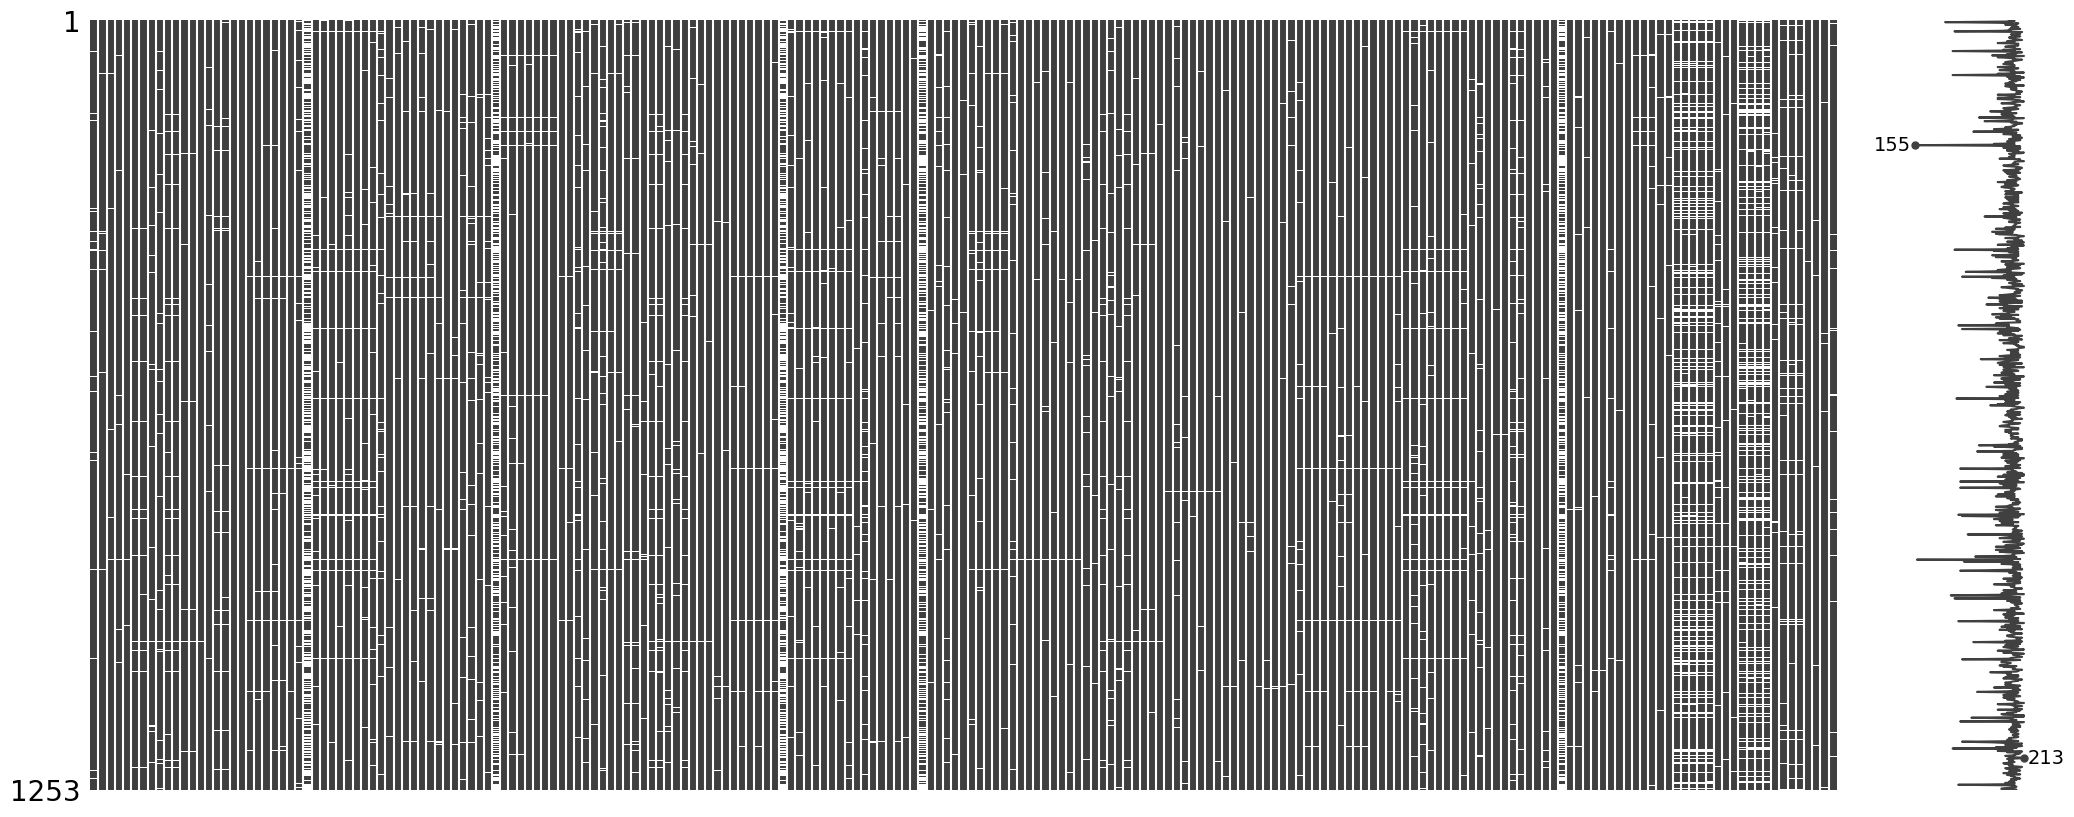

In [18]:
msno.matrix(X_train.mask(~maskz))
plt.show()

In [19]:
X_train.drop_duplicates()

,feature004,feature008,feature010,feature011,feature015,feature022,feature023,feature024,feature025,feature027,feature028,feature030,feature031,feature032,feature034,feature041,feature042,feature048,feature052,feature060,feature063,feature064,feature065,feature066,feature068,feature072,feature073,feature076,feature077,feature078,feature079,feature080,feature081,feature082,feature083,feature090,feature092,feature096,feature097,feature099,feature101,feature102,feature103,feature104,feature105,feature106,feature107,feature108,feature109,feature113,feature126,feature127,feature128,feature129,feature130,feature131,feature135,feature201,feature202,feature211,feature271,feature274,feature275,feature276,feature279,feature281,feature282,feature286,feature295,feature296,feature297,feature298,feature301,feature302,feature303,feature304,feature317,feature325,feature336,feature337,feature338,feature339,feature341,feature345,feature347,feature349,feature350,feature351,feature352,feature353,feature354,feature355,feature356,feature357,feature363,feature366,feature367,feature368,feature369,feature377,feature378,feature386,feature388,feature408,feature409,feature410,feature411,feature412,feature413,feature414,feature416,feature417,feature418,feature419,feature420,feature421,feature424,feature425,feature426,feature427,feature428,feature429,feature430,feature432,feature433,feature434,feature437,feature438,feature439,feature440,feature441,feature442,feature443,feature445,feature446,feature447,feature448,feature449,feature453,feature454,feature455,feature456,feature457,feature458,feature460,feature461,feature468,feature469,feature470,feature471,feature472,feature473,feature474,feature475,feature476,feature477,feature478,feature479,feature480,feature481,feature483,feature484,feature485,feature486,feature487,feature488,feature489,feature490,feature491,feature492,feature494,feature495,feature496,feature497,feature498,feature500,feature501,feature511,feature512,feature520,feature521,feature522,feature523,feature524,feature525,feature526,feature527,feature528,feature540,feature541,feature542,feature545,feature546,feature547,feature553,feature556,feature557,feature558,feature559,feature561,feature562,feature564,feature568,feature569,feature570,feature572,feature576,feature577,feature578,feature586,feature587,feature589,feature590
100,1740.3297,0.1222,0.0046,0.0041,14.4227,-5443.00,2524.50,-3894.00,-136.2500,1.9935,7.1567,2.8111,0.2139,3.3339,8.7947,76.52,2.859,1.0314,61.7340,24.8064,115.1391,3.0204,15.1936,19.4876,1.2378,92.6162,NaN,-0.0560,NaN,-0.0100,-0.0927,NaN,0.0332,-0.0182,-0.0383,0.1516,-0.0100,0.0001,0.0856,-0.0238,-0.0002,0.0000,0.0419,-0.0062,-0.0001,-0.0016,-0.0006,0.0968,0.0670,0.4598,1.0260,2.643,0.6230,3.042,0.0473,0.7388,45.4822,3.57,10.66,0.1419,33.5037,25.1991,92.7966,0.1302,0.0008,0.0206,0.0185,3.1867,157.6283,144.7999,462.0483,259.3317,0.0315,0.8536,0.2934,0.0266,7.6145,7.9602,3.8610,7.5842,3.0640,3.0639,0.0934,28.3456,NaN,0.0426,0.0348,0.0172,0.0284,0.0254,0.0382,0.0460,0.0218,1.0511,0.0095,0.0056,0.0040,0.0033,0.0033,0.0010,0.0012,0.0086,0.0,1.6137,6.9263,2.6232,2.0302,3.4787,17.6108,28.5952,6.7039,2.9451,9.7971,0.0000,0.0000,1.8744,64.5786,1.1136,5.0414,1.4580,2.7690,4.7245,4.8750,12.1608,27.9147,463.8532,1.0200,3.3918,32.0158,38.8052,3.6894,0.8446,1.3381,1.0059,0.4918,1.1148,0.2150,0.9581,6.6590,8.4547,15.3453,1.0401,8.5501,7.7206,2.0332,46.3586,3.5904,42.9728,4.0618,8.6167,9.9532,118.1968,70.1610,51.9971,1.4509,28.6441,7.1654,0.0,1.0185,90.7584,253.4494,63.1149,398.9950,69.4902,89.5143,273.1928,511.5385,120.5479,32.7543,4.0185,2.8463,0.0723,2.8928,20.5960,20.3185,0.0000,0.0000,45.0704,0.0000,11.8498,5.0564,0.0,31.9522,0.1350,3.8734,3.8834,2.3835,5.3129,2.6477,1.4694,11.2407,0.0026,7.1160,0.8482,0.0390,10.3379,3.0934,1.5614,1.0105,0.0850,48.9498,NaN,NaN,NaN,NaN,2.3027,0.0783,2.3592,10.9671,2.8818,0.0199,0.0031,53.6369
1299,711.0258,0.1252,-0.0032,-0.0035,5.3617,-5295.25,2755.25,-4060.50,212.7500,1.9790,7.3153,2.5333,0.2114,3.2174,8

### Imputation of Data Using KNN

In [20]:
# prior to any imputation we concatenate the X and y because model won't accept any nulls on features

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)


train_data = pd.concat([X_train, y_train], axis=1)
train_imputed = pd.DataFrame(imputer.fit_transform(train_data),columns = train_data.columns)

#we impute target feature as well on test data because model won't admit null values
test_data = pd.concat([X_test, y_test], axis=1)
test_imputed = pd.DataFrame(imputer.fit_transform(train_data),columns = test_data.columns)


In [21]:
# assigning all variables back 
y_train = train_imputed['class']
y_test = test_imputed['class']

train_imputed.drop('class', axis='columns', inplace=True)
test_imputed.drop('class', axis='columns', inplace=True)

X_train = train_imputed
X_test = test_imputed

### Boruta for Feature Selection 

Here we are using boruta for feature selection:

- **Green:** Stands for features boruta is quite sure are useful for the model, so we should keep them

- **Blue:** Stands for features boruta is not quite sure whether will have a significant impact on the model or not (HERE WE COULD DECIDE TO KEEP IT OR NOT), for this Script we will keep them!

- **Red**: Features to be dropped

In [22]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
import numpy as np
###initialize Boruta
forest = RandomForestClassifier(
   n_jobs = -1, 
   max_depth = 8,
    class_weight='balanced'
)
boruta = BorutaPy(
   estimator = forest, 
   n_estimators = 'auto',
   max_iter = 50 # number of trials to perform
    , perc = 60,
    random_state=4242
)
### fit Boruta (it accepts np.array, not pd.DataFrame)
boruta.fit(X_train.values, y_train.values.ravel())
### print results
green_area = X_train.columns[boruta.support_].to_list()
blue_area = X_train.columns[boruta.support_weak_].to_list()
print('features to keep', green_area)
print('features to that the model is not quite sure whether work or no', blue_area)

features to keep ['feature010', 'feature015', 'feature032', 'feature034', 'feature041', 'feature042', 'feature060', 'feature064', 'feature065', 'feature066', 'feature073', 'feature077', 'feature079', 'feature080', 'feature090', 'feature092', 'feature103', 'feature104', 'feature107', 'feature113', 'feature126', 'feature127', 'feature128', 'feature130', 'feature131', 'feature201', 'feature211', 'feature271', 'feature295', 'feature296', 'feature317', 'feature325', 'feature347', 'feature349', 'feature352', 'feature378', 'feature386', 'feature411', 'feature417', 'feature418', 'feature421', 'feature424', 'feature426', 'feature427', 'feature429', 'feature432', 'feature440', 'feature445', 'feature446', 'feature447', 'feature453', 'feature454', 'feature455', 'feature456', 'feature461', 'feature469', 'feature478', 'feature486', 'feature488', 'feature489', 'feature490', 'feature492', 'feature511', 'feature520', 'feature526', 'feature561', 'feature562', 'feature564', 'feature572', 'feature576', 'f

**Green**: Stands for features boruta is quite sure are useful for the model, so we should keep them

**Blue**: Stands for features boruta is not quite sure whether will have a significant impact on 
the model or not (HERE WE COULD DECIDE TO KEEP IT OR NOT), for this Variance we will keep them!

In [23]:
print('Green',len(green_area))
print('Blue', len(blue_area))

Green 72
Blue 18


In [24]:
X_train = pd.concat([X_train[green_area], X_train[blue_area]], axis=1)
X_test = pd.concat([X_test[green_area], X_test[blue_area]], axis=1)

# Pedro`s code

In [25]:
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X_train, y_train)

print(f'''Shape of X before SMOTE: {X_train.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

Shape of X before SMOTE: (1253, 90)
Shape of X after SMOTE: (2346, 90)

Balance of positive and negative classes (%):


0.0    50.0
1.0    50.0
Name: class, dtype: float64

Accuracy = 1.00
Recall = 1.00



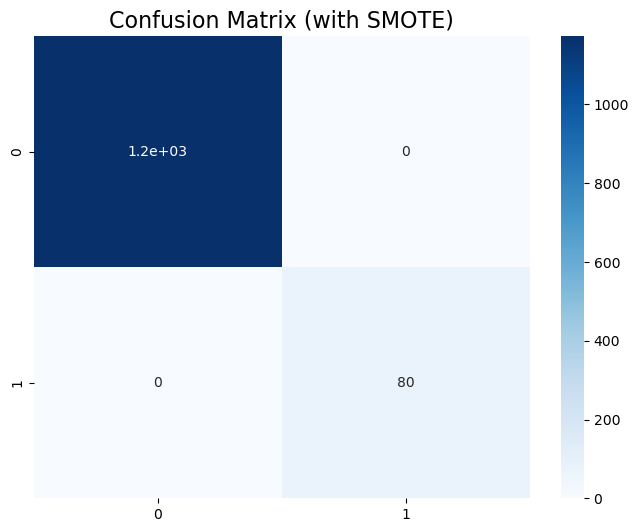

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

#X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.25, random_state=42 )

model = RandomForestClassifier(random_state=42)
model.fit(X_sm, y_sm)
preds = model.predict(X_test)

print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix (with SMOTE)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');